In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os

from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader
from torchvision import datasets, transforms
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/





In [ ]:
batch_size = 64
epochs = 10
log_interval = 10
save_model = True
lr = 0.01
gamma = 0.7
no_of_classes = 5

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_csv  = pd.read_csv("../input/drlabels/trainLabels.csv")
#test_info  = pd.read_excel("/content/drive/MyDrive/DR_Noman_1000/testLabels.xlsx")
class_count = class_info['level'].value_counts().values.tolist()

In [ ]:
print(len(train_csv))
#print(len(test_info))
print(class_count)

3000

[2248, 442, 182, 70, 58]


In [ ]:
train_csv.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


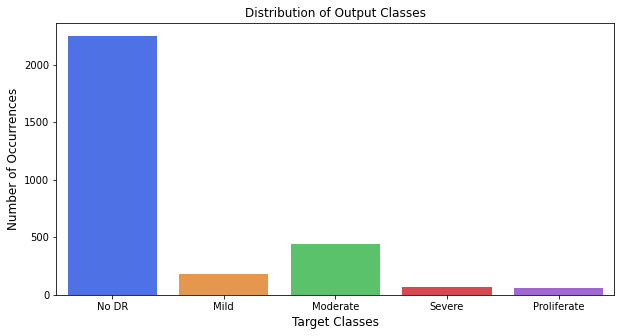

In [ ]:
# EDA
import seaborn as sns
counts = train_csv['level'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(counts.index, counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

In [ ]:
# image count in training folder
dir_path = r'../input/drnomanall/train'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 3000


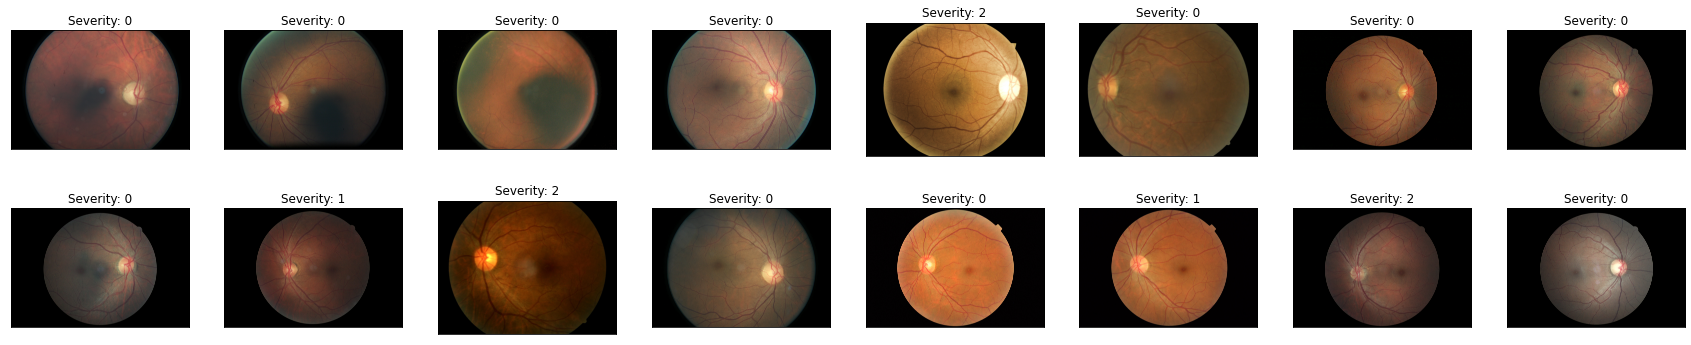

In [ ]:
# display 16 images from training set
from PIL import Image, ImageFile
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(dir_path)
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(dir_path + "/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['image'] == img.split('.')[0], 'level'].values[0]
    ax.set_title('Severity: %s'%lab)

In [ ]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.jpeg')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
# data augmentation
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [ ]:
train_path = "../input/drnomanall/train"

In [ ]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)

In [ ]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNet.from_name('efficientnet-b1')
for param in model.parameters():
    param.requires_grad = True

num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, no_of_classes)
model = model.to(device)

In [ ]:
num_train

3000

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)

In [ ]:
print(f"training examples contain : {len(train_data)}")
#print(f"testing examples contain : {len(test_data)}")

print(f"train loader contain : {len(trainloader)}")
print(f"valid loader contain : {len(validloader)}")

training examples contain : 3000

train loader contain : 38

valid loader contain : 10


In [ ]:
# LOAD ONE BATCH OF Training SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])

Label shape : torch.Size([64])


labels: tensor([2, 0, 0, 0, 0, 2, 1, 0, 3, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0,

        4, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 3, 2,

        0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


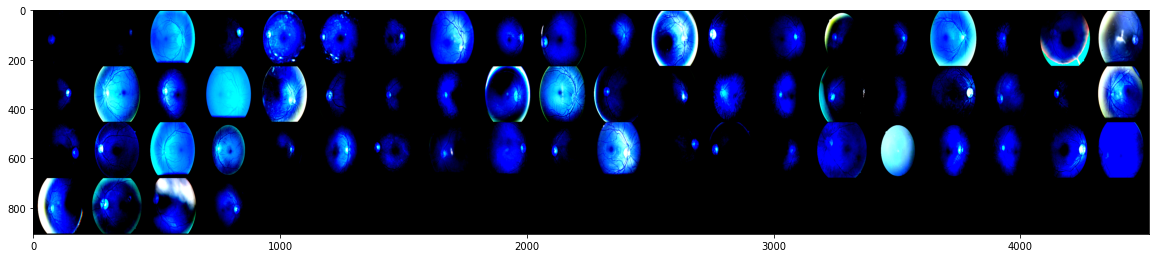

In [ ]:
# plotting the images of loaded batch with given fig size and frame data    
import torchvision
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)  

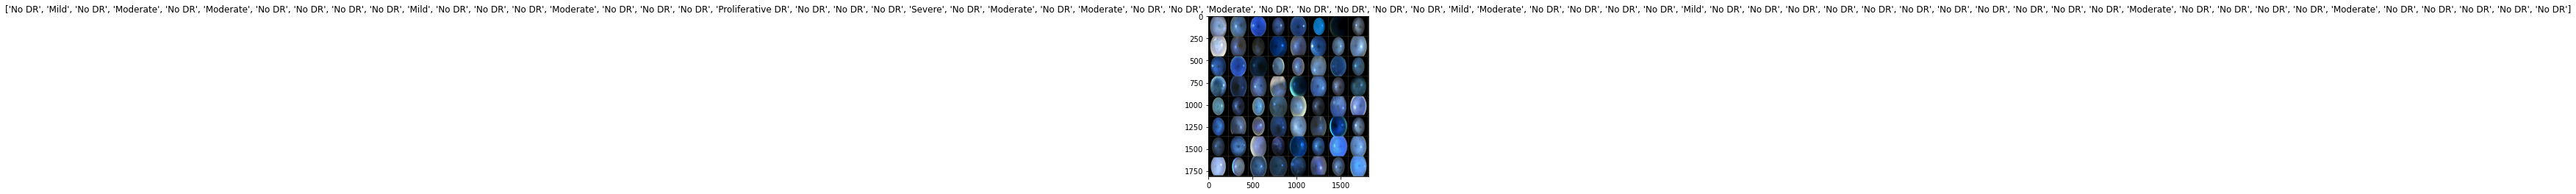

In [ ]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [ ]:
from torchvision.models.efficientnet import EfficientNet_B0_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision import datasets, transforms, models

out_ftrs = 5

#EfficientNet
from efficientnet_pytorch import EfficientNet
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
efficientnet ._fc= torch.nn.Linear(in_features=efficientnet._fc.in_features, out_features=out_ftrs, bias=True)

model = efficientnet


#model = models.efficientnet_b0(EfficientNet_B0_Weights)

#num_ftrs = model.fc.in_features 
 
  
#model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.0001) 

from torch.optim import lr_scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

Loaded pretrained weights for efficientnet-b0


In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
# model_save_name = 'DR_classifier_Noman_EfficientNet.pt'
# torch.save(model.state_dict(), f"/content/drive/MyDrive/DR_Noman_3000/{model_save_name}")
torch.save(model.state_dict(), 'DR_classifier_Noman_EfficientNet.pth')

In [ ]:
path = "./DR_classifier_Noman_EfficientNet.pth"
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [ ]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 

4013953


In [ ]:
# for epoch in range(1, epochs + 1):
#     train(log_interval, model, device, train_loader, optimizer, epoch)
#     test(model, device, val_loader)
#     scheduler.step()

# torch.save({
#             'epoch': epochs,
#             'model': model,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict()            
#             }, path)

In [ ]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    #val_acc = [] , [], []
    valid_loss_min = np.Inf 
    model.train()
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed") 
      test_loss = 0
      accuracy = 0
      #val_accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))

      train_losses.append(running_loss/len(validloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      #val_acc.append(val_accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)

        # early_stopping(train_losses, test_losses)
        # if early_stopping.early_stop:
        #     print("We are at epoch:", i)
        #     break    
    print('Training Completed Succesfully !')    
    return train_losses, test_losses, acc 

In [ ]:
import time
t0 = time.time()

In [ ]:
train_losses, valid_losses, acc = train_and_test(10)
print("Training time:", time.time()-t0)

Model Training started.....

 epoch 1 batch 10 completed

 epoch 1 batch 20 completed

 epoch 1 batch 30 completed

validation started for 1

Epoch: 1/10..  Training Loss: 1.242..  Valid Loss: 1.022..  Valid Accuracy: 0.763

Validation loss decreased (inf --> 1.021827).  Saving model ...

 epoch 2 batch 10 completed

 epoch 2 batch 20 completed

 epoch 2 batch 30 completed

validation started for 2

Epoch: 2/10..  Training Loss: 0.811..  Valid Loss: 0.835..  Valid Accuracy: 0.755

Validation loss decreased (1.021827 --> 0.835129).  Saving model ...

 epoch 3 batch 10 completed

 epoch 3 batch 20 completed

 epoch 3 batch 30 completed

validation started for 3

Epoch: 3/10..  Training Loss: 0.691..  Valid Loss: 0.798..  Valid Accuracy: 0.755

Validation loss decreased (0.835129 --> 0.797808).  Saving model ...

 epoch 4 batch 10 completed

 epoch 4 batch 20 completed

 epoch 4 batch 30 completed

validation started for 4

Epoch: 4/10..  Training Loss: 0.609..  Valid Loss: 0.856..  Valid

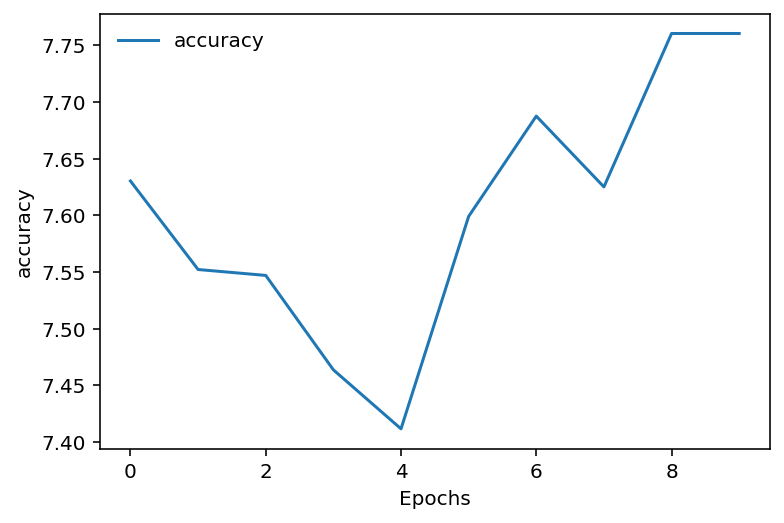

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)